# Urbanization Process and Population in Modern China

##### Ame Liu 22910358@student.uwa.edu.au


In [36]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import folium
import os
from time import sleep
from IPython.display import clear_output
mpl.rcParams['lines.linewidth'] = 2.0
from matplotlib.animation import FuncAnimation



## Preparation

In [28]:
def three_frame(world, n_seq, seed=17):
    np.random.seed(seed)
    plt.figure(figsize=(10, 4))

    for i, n in enumerate(n_seq):
        plt.subplot(1, 3, i+1)
        world.loop(n)
        world.draw()

    plt.tight_layout()


def savefig(filename, **options):
    print("Saving figure to file", filename)
    plt.savefig(filename, **options)


def underride(d, **options):
    for key, val in options.items():
        d.setdefault(key, val)

    return d


def decorate(**options):
    loc = options.pop("loc", "best")
    if options.pop("legend", True):
        legend(loc=loc)

    plt.gca().set(**options)
    plt.tight_layout()


def legend(**options):
    underride(options, loc="best", frameon=False)

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, **options)

def draw_array(array, **options):
    n, m = array.shape
    options = underride(options,
                        cmap='Greens',
                        alpha=0.7,
                        vmin=0, vmax=1,
                        interpolation='none',
                        origin='upper',
                        extent=[0, m, 0, n])

    plt.axis([0, m, 0, n])
    plt.xticks([])
    plt.yticks([])

    return plt.imshow(array, **options)

## Parent class for 2-D cellular automata

In [62]:
class Cell2D:
    def __init__(self, n, m=None):
        m = n if m is None else m
        self.array = np.zeros((n, m), np.uint8)

    def add_cells(self, row, col, *strings):
        for i, s in enumerate(strings):
            self.array[row+i, col:col+len(s)] = np.array([int(b) for b in s])

    def loop(self, iters=1):
        for i in range(iters):
            self.step()

    def draw(self, **options):
        draw_array(self.array, **options)

    def animate(self, frames, interval):
        fig, ax = plt.subplots()

        def update(frame):
            print(f"Updating frame {frame}")
            ax.clear()
            print("Cleared ax")
            self.loop(1)  # advance the simulation one step
            print("Looped")
            self.draw()   # draw the current state to the plot
            print("Drew")

        print("Creating animation")
        anim = mpl.animation.FuncAnimation(fig, update, frames=frames, interval=interval)
        print("Animation created")
        return anim




def distances_from(n, i, j):
    X, Y = np.indices((n, n))
    return np.hypot(X - i, Y - j)


def make_locs(n, m):
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)


def make_visible_locs(vision):
    def make_array(d):
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a

    arrays = [make_array(d) for d in range(1, vision + 1)]
    return np.vstack(arrays)

## Agent-Based Modeling
Add different attributes for residents.

In [63]:
#Define residents
class Agent:
    def __init__(self, loc, params, sugarscape):
        self.loc = tuple(loc)
        self.age = 0
        #Set vision for residents
        max_vision = params.get('max_vision', 6)

        #Initial residents age
        #Determine how long each person will live
        min_lifespan = params.get('min_lifespan', 30)
        max_lifespan = params.get('max_lifespan', 70)

        #Set the initial wealth for each resident
        min_sugar = params.get('min_sugar', 10)
        max_sugar = params.get('max_sugar', 100)


        self.vision = np.random.randint(1, max_vision + 1)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.sugar = np.random.uniform(min_sugar, max_sugar)
        self.replicate_prob = 0.15
        self.sugarscape = sugarscape
        self.income = 0
        self.consumption = 0

        #Fertility
    def replication(self):
        #Property over 15 and age under 40 to have children
        if random.random() < self.replicate_prob and self.sugar > 15 and self.age < 40:
            self.sugarscape.add_agent()

    def step(self, env):
        self.loc = env.look_and_move(self)
        level = env.harvest(self.loc)
        #Incomes
        #Income is linked to property and we are given the following coefficients
        self.income = (1 + (self.sugar / 100)) * level

        #Consumption
        self.consumption = (1 + (self.age / 25)) * level
        self.sugar += self.income - self.consumption

        #Age
        self.age += 1

        #Maximum population limit
        if len(env.agents) < 300:
            self.replication()
        #Death
    def is_starving(self):
        #1.Property less than 0 resident will death
        return self.sugar < 0

    def is_old(self):
        #2.Death when maximum life expectancy is reached
        return self.age > self.lifespan

## Build Urban Systems
Build different urban areas.

In [64]:
class Urban_Humanities(Cell2D):
    def __init__(self, n, **params):
        super().__init__(n)
        self.points = None
        self.occupied = None
        self.agents = None
        self.n = n
        self.params = params
        self.agent_count_seq = []
        self.capacity = self.make_capacity()
        self.array = self.capacity.copy()

        #The city is divided into 5 areas, 4,3,2,1,0, from the center to the outside, with 4 being the city center and 0 being the countryside.

        self.agent_level_count = {0: [], 1: [], 2: [], 3: [], 4: []}

        self.agent_level_wealth = {0: [], 1: [], 2: [], 3: [], 4: []}

        self.agent_level_highest_wealth = {0: [], 1: [], 2: [], 3: [], 4: []}

        self.agent_level_lowest_wealth = {0: [], 1: [], 2: [], 3: [], 4: []}

        self.wealth_gap = {0: [], 1: [], 2: [], 3: [], 4: []}


        self.make_agents()

    def make_capacity(self):
        dist = distances_from(self.n, 25, 25)
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a

    def make_agents(self):
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)

        np.random.shuffle(locs)
        #Initial the number of residents.
        num_agents = self.params.get('num_agents', 100)
        assert (num_agents <= len(locs))
        self.agents = [Agent(locs[i], self.params, self)
                       for i in range(num_agents)]
        self.occupied = set(agent.loc for agent in self.agents)

    def look_and_move(self, agent):
        locs = make_visible_locs(agent.vision)
        locs = (locs + agent.loc) % self.n
        locs = [tuple(loc) for loc in locs]

        empty_locs = [loc for loc in locs if loc not in self.occupied]

        if len(empty_locs) == 0:
            return agent.loc
        t = [self.array[loc] for loc in empty_locs]

        #If income is less than consumption residents will move from their current area to other areas.
        if agent.income < agent.consumption:
            i = np.argmin(t)
        else:
            i = np.argmax(t)

        return empty_locs[i]

    def harvest(self, loc):
        sugar = self.array[loc]
        return sugar

    def step(self):
        replace = self.params.get('replace', False)
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            if agent.loc in self.occupied:
                self.occupied.remove(agent.loc)

            agent.step(self)

            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                self.occupied.add(agent.loc)

        self.agent_count_seq.append(len(self.agents))

        agent_by_level = {0: [], 1: [], 2: [], 3: [], 4: []}
        for agent in self.agents:
            level = self.harvest(agent.loc)
            agent_by_level[level].append(agent)
        for i in range(5):
            self.agent_level_count[i].append(len(agent_by_level[i]))
            self.agent_level_wealth[i].append(sum([agent.sugar for agent in agent_by_level[i]]) / len(agent_by_level[i]))
            self.agent_level_highest_wealth[i].append(max([agent.sugar for agent in agent_by_level[i]]))
            self.agent_level_lowest_wealth[i].append(min([agent.sugar for agent in agent_by_level[i]]))

        return len(self.agents)

    def add_agent(self):
        new_agent = Agent(self.random_loc(), self.params, self)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent

    def random_loc(self):
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

    def draw(self):
        draw_array(self.array, cmap='YlOrRd', vmax=9, origin='lower')

        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]

    def get_coords(self):
        agents = self.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys


## Drawing
All images are saved in the current directory.

### The initial graph
The total area is 50x50 in size
The initial residents are 100

Saving figure to file Initial_Residents.png


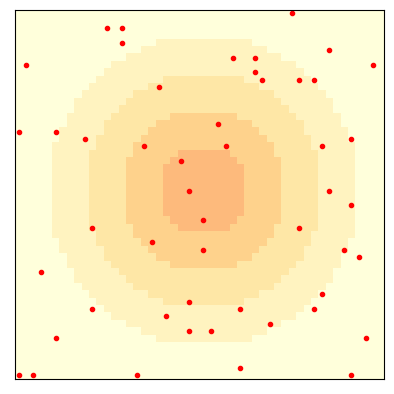

In [65]:
env = Urban_Humanities(50, num_agents=50)
env.draw()
savefig('Initial_Residents.png')

### Demo for the urbanization process
The demo is divided into two phases:
Step 1: Population growth and moving towards the city center
Step2: The population gradually spreads outward and stops growing

Frames and intervals can be changed by your prefer

Creating animation
Animation created
Updating frame 0
Cleared ax
Looped
Drew
Updating frame 0
Cleared ax
Looped
Drew
Updating frame 1
Cleared ax
Looped
Drew
Updating frame 2
Cleared ax
Looped
Drew
Updating frame 3
Cleared ax
Looped
Drew
Updating frame 4
Cleared ax
Looped
Drew
Updating frame 5
Cleared ax
Looped
Drew
Updating frame 6
Cleared ax
Looped
Drew
Updating frame 7
Cleared ax
Looped
Drew
Updating frame 8
Cleared ax
Looped
Drew
Updating frame 9
Cleared ax
Looped
Drew
Updating frame 10
Cleared ax
Looped
Drew
Updating frame 11
Cleared ax
Looped
Drew
Updating frame 12
Cleared ax
Looped
Drew
Updating frame 13
Cleared ax
Looped
Drew
Updating frame 14
Cleared ax
Looped
Drew
Updating frame 15
Cleared ax
Looped
Drew
Updating frame 16
Cleared ax
Looped
Drew
Updating frame 17
Cleared ax
Looped
Drew
Updating frame 18
Cleared ax
Looped
Drew
Updating frame 19
Cleared ax
Looped
Drew
Updating frame 20
Cleared ax
Looped
Drew
Updating frame 21
Cleared ax
Looped
Drew
Updating frame 22
Cleared ax
Lo

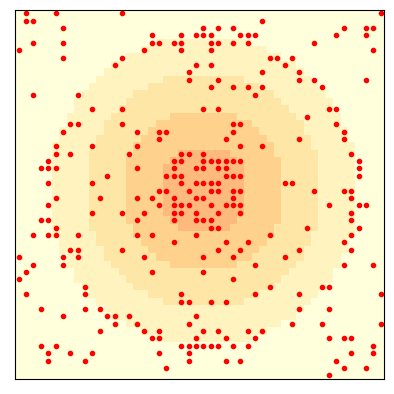

In [66]:
anim = env.animate(frames=100, interval= 0.1)
anim.save('output.gif', writer='pillow')

### Heat map of urban population distribution in Beijing in 2022

In [67]:
data = (
    np.random.normal(size=(100, 3)) *
    np.array([[0.1, 0.1, 0.1]]) +
    np.array([[40, 116.5, 1]])
).tolist()
data[:3]

from folium.plugins import HeatMap
Beijing = folium.Map([39.93, 116.38], tiles='stamentoner', zoom_start=10)
HeatMap(data).add_to(Beijing)

folium.CircleMarker(
    location=[39.93, 116.38],
    radius=40,
    color='red',
    fill=False,
).add_to(Beijing)

folium.CircleMarker(
    location=[39.93, 116.38],
    radius=80,
    color='red',
    fill=False,
).add_to(Beijing)

folium.CircleMarker(
    location=[39.93, 116.38],
    radius=120,
    color='red',
    fill=False,
).add_to(Beijing)

folium.CircleMarker(
    location=[39.93, 116.38],
    radius=160,
    color='red',
    fill=False,
).add_to(Beijing)

folium.CircleMarker(
    location=[39.93, 116.38],
    radius=230,
    color='red',
    fill=False,
).add_to(Beijing)

folium.Marker(
    location=[39.93, 116.38],
    popup='4',
    icon=folium.Icon(color='purple', icon='info-sign')
).add_to(Beijing)

folium.Marker(
    location=[39.93, 116.45],
    popup='3',
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(Beijing)

folium.Marker(
    location=[40, 116.48],
    popup='2',
    icon=folium.Icon(color='green', icon='info-sign')
).add_to(Beijing)

folium.Marker(
    location=[40.01, 116.55],
    popup='1',
    icon=folium.Icon(color='orange', icon='info-sign')
).add_to(Beijing)

folium.Marker(
    location=[40.08, 116.58],
    popup='0',
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(Beijing)
Beijing.save(os.path.join('Beijing.html'))
Beijing

-Blue-Area 0

-Orange-Area 1

-Green-Area 2

-Red-Area 3

-Purple-Area 4

### Total number of people/year in different areas

Saving figure to file Population


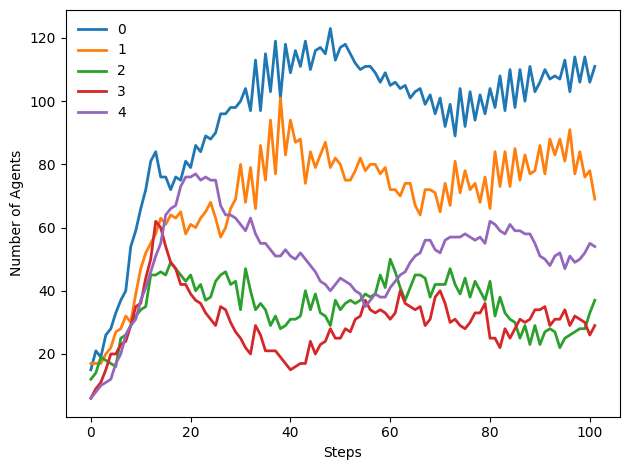

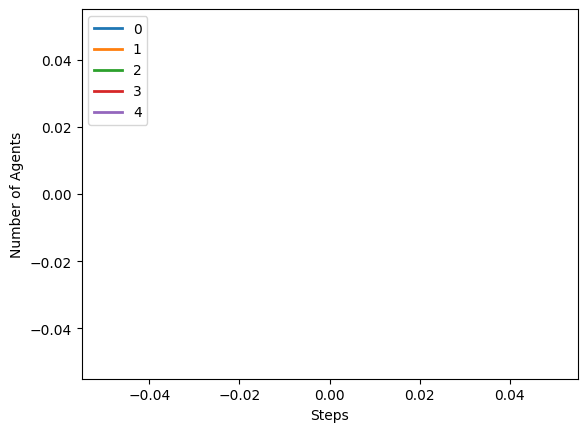

In [69]:
for i, agents in env.agent_level_count.items():
    plt.plot(agents,color='C'+str(i), label=i)
decorate(xlabel='Steps', ylabel='Number of Agents', loc='upper left')
savefig('Population')

from matplotlib.animation import FuncAnimation
def update(i):
    plt.clf()
    for j, agents in env.agent_level_count.items():
        plt.plot(agents[:i], color='C'+str(j), label=str(j))
    plt.xlabel('Steps')
    plt.ylabel('Number of Agents')
    plt.legend(loc='upper left')

fig = plt.figure()
anim = FuncAnimation(fig, update, frames=len(env.agent_level_count[0]), repeat=True)

anim.save('line_graph.gif', writer='pillow')


### Wealth per capita/year in different areas

Saving figure to file Average_Wealth


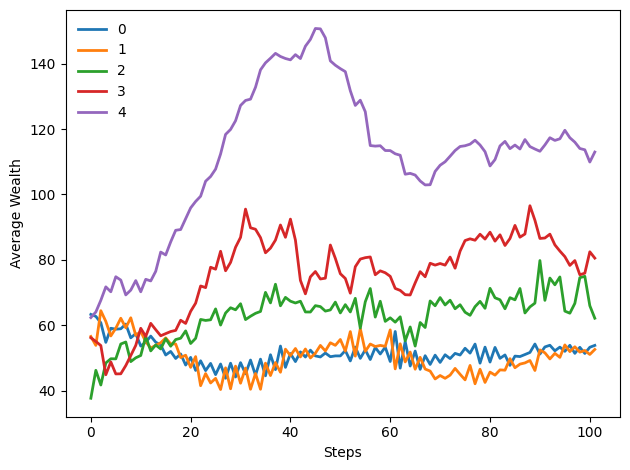

In [83]:
for i, agents in env.agent_level_wealth.items():
    plt.plot(agents,color='C'+str(i), label=i)
decorate(xlabel='Steps', ylabel='Average Wealth', loc='upper left')
savefig('Average_Wealth')

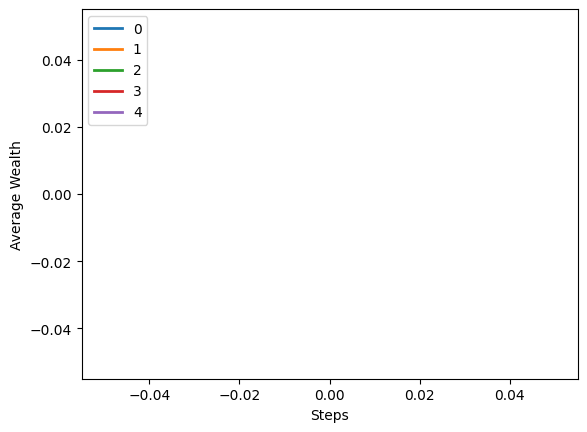

In [70]:
def update(i):
    plt.clf()
    for j, agents in env.agent_level_wealth.items():
        plt.plot(agents[:i], color='C'+str(j), label=str(j))
    plt.xlabel('Steps')
    plt.ylabel('Average Wealth')
    plt.legend(loc='upper left')

fig = plt.figure()
anim = FuncAnimation(fig, update, frames=len(env.agent_level_wealth[0]), repeat=True)

anim.save('average_wealth.gif', writer='pillow')

### Highest resident wealth/year in different areas

Saving figure to file Highest_Wealth


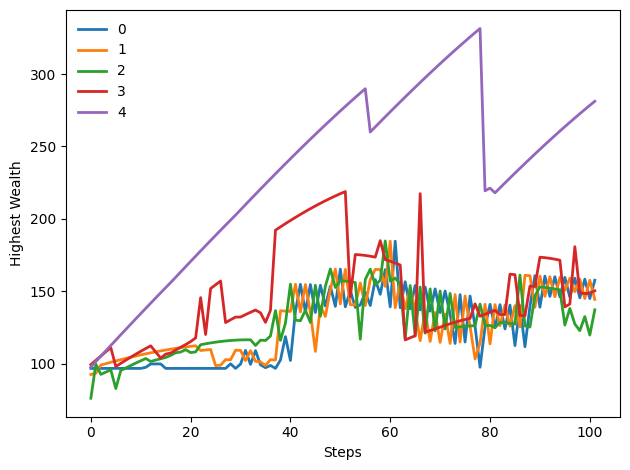

Saving figure to file Highest_Wealth


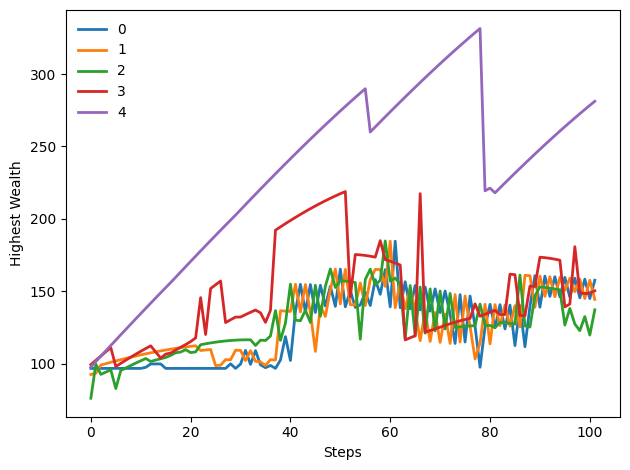

In [82]:
for i, agents in env.agent_level_highest_wealth.items():
    plt.plot(agents,color='C'+str(i), label=i)
decorate(xlabel='Steps', ylabel='Highest Wealth', loc='upper left')
savefig('Highest_Wealth')

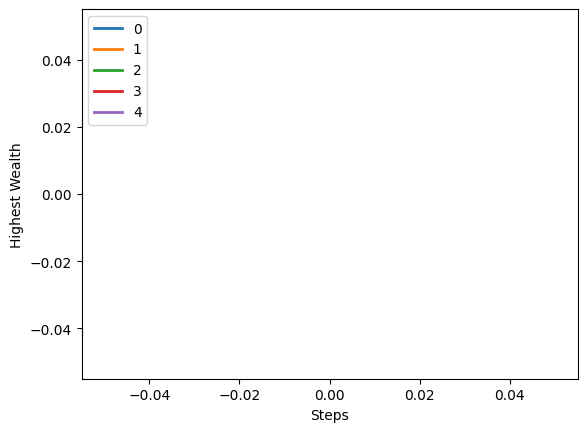

In [71]:
def update(i):
    plt.clf()
    for j, agents in env.agent_level_highest_wealth.items():
        plt.plot(agents[:i], color='C'+str(j), label=str(j))
    plt.xlabel('Steps')
    plt.ylabel('Highest Wealth')
    plt.legend(loc='upper left')

fig = plt.figure()
anim = FuncAnimation(fig, update, frames=len(env.agent_level_highest_wealth[0]), repeat=True)

anim.save('highest_wealth.gif', writer='pillow')

### Lowest resident wealth/year in different areas

Saving figure to file Lowest_Wealth


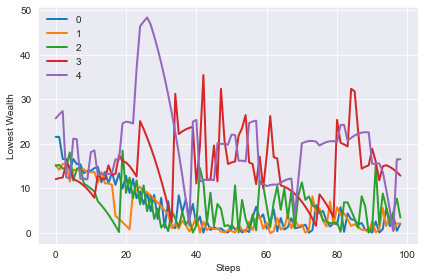

In [376]:
for i, agents in env.agent_level_lowest_wealth.items():
    plt.plot(agents,color='C'+str(i), label=i)
decorate(xlabel='Steps', ylabel='Lowest Wealth', loc='upper left')
savefig('Lowest_Wealth')


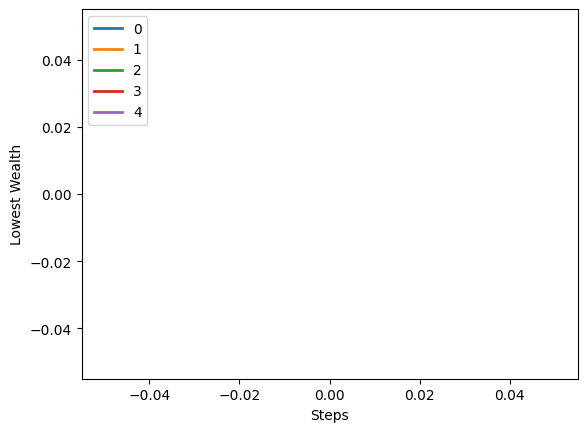

In [72]:
from matplotlib.animation import FuncAnimation

def update(i):
    plt.clf()
    for j, agents in env.agent_level_lowest_wealth.items():
        plt.plot(agents[:i], color='C'+str(j), label=str(j))
    plt.xlabel('Steps')
    plt.ylabel('Lowest Wealth')
    plt.legend(loc='upper left')

fig = plt.figure()
anim = FuncAnimation(fig, update, frames=len(env.agent_level_lowest_wealth[0]), repeat=True)

anim.save('lowest_wealth.gif', writer='pillow')
